## 4.4 Model Selection, Underfitting, and Overfitting
### 4.4.1 Training Error and Generalization Error
### 4.4.2 Model Selection
### 4.4.3 Underfitting or Overfitting
### 4.4.4 Polynomial Regression
$y=5+1.2x-3.4\frac{x^2}{2!}+5.6\frac{x^3}{3!}+\epsilon,\epsilon\sim\mathcal{N}(0,0.1^2)$

In [1]:
from d2l import mxnet as d2l
from mxnet import gluon, np, npx
from mxnet.gluon import nn
import math
npx.set_np()

In [3]:
max_degree=20   # 多项式最大维度
n_train, n_test=100,100 # 训练集 和 测试集 的大小
true_w=np.zeros(max_degree)
true_w[0:4]=np.array([5,1.2,-3.4,5.6])

features=np.random.normal(size=(n_train+n_test,1))
np.random.shuffle(features)
poly_features=np.power(features,np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    poly_features[:,i]/=math.gamma(i+1) # gamma(n)=(n-1)!
labels=np.dot(poly_features,true_w)
labels+=np.random.normal(scale=0.1,size=labels.shape)
features[:2], poly_features[:2,:], labels[:2]

(array([[-2.0246897 ],
        [-0.12618658]]),
 array([[ 1.0000000e+00, -2.0246897e+00,  2.0496840e+00, -1.3833247e+00,
          7.0020086e-01, -2.8353789e-01,  9.5679365e-02, -2.7674433e-02,
          7.0040175e-03, -1.5756624e-03,  3.1902271e-04, -5.8720187e-05,
          9.9075123e-06, -1.5430493e-06,  2.2315685e-07, -3.0121555e-08,
          3.8116754e-09, -4.5396822e-10,  5.1063598e-11, -5.4414702e-12],
        [ 1.0000000e+00, -1.2618658e-01,  7.9615265e-03, -3.3487927e-04,
          1.0564317e-05, -2.6661502e-07,  5.6072058e-09, -1.0107916e-10,
          1.5943543e-12, -2.2354013e-14,  2.8207764e-16, -3.2358555e-18,
          3.4026795e-20, -3.3028654e-22,  2.9769806e-24, -2.5043665e-26,
          1.9751090e-28, -1.4660722e-30,  1.0277702e-32, -6.8258311e-35]]),
 array([-12.085393 ,   4.8279324]))

In [4]:
def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset"""
    metric=d2l.Accumulator(2)
    for X,y in data_iter:
        l=loss(net(X),y)
        metric.add(d2l.reduce_sum(l),l.size)
    return metric[0]/metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = gluon.loss.L2Loss()
    net = nn.Sequential()
    net.add(nn.Dense(1, use_bias=False))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size)
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', 
        xlim=[1, num_epochs], ylim=[1e-3, 1e2], legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, 
                (evaluate_loss(net, train_iter, loss), 
                (evaluate_loss(net, test_iter, loss))))
    print('weight:', net[0].weight.data().asnumpy())

weight: [[ 4.9793777  1.6040726 -3.2823029  4.567934 ]]


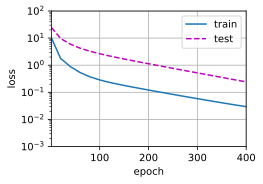

In [6]:
# Third-Order Polynomial Function Fitting(Normal)
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

weight: [[3.7466784 2.9131374]]


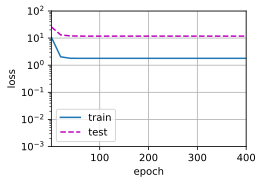

In [7]:
# Linear Function Fitting(Underfitting)
train(poly_features[:n_train,:2],poly_features[n_train:,:2],labels[:n_train],labels[n_train:])

weight: [[ 5.0072761e+00  1.2534662e+00 -3.4158013e+00  5.2907357e+00
  -1.1150929e-01  1.2263523e+00  4.7446072e-02  7.4304238e-02
  -1.8088480e-02 -4.0781185e-02 -5.9725046e-02  2.3120746e-03
  -6.0772747e-02 -3.8816758e-02  4.9879309e-02 -1.8271429e-02
  -4.7303163e-02 -6.2284980e-02  8.3555430e-03  5.7567604e-02]]


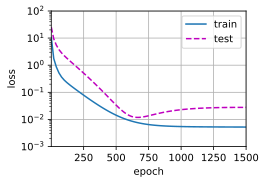

In [8]:
# Higher-Order Polynomial Function Fitting(Overfitting)
train(poly_features[:n_train, :], poly_features[n_train:, :], 
    labels[:n_train], labels[n_train:], num_epochs=1500)